In [219]:
from datasets import load_dataset, Image, Dataset
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
import torch.nn as nn
from transformers import ViTForImageClassification
import torch.optim as optim
import torch
from torchvision.transforms import ToTensor, Resize, Compose

In [229]:
labels = pd.read_csv("/kaggle/input/spr-x-ray-age/train_age.csv").sort_values("imageId")["age"].tolist()[:100]
train_path = "/kaggle/input/spr-x-ray-age/kaggle/kaggle/train/"
train_files = sorted(os.listdir(train_path))[:100]       
ds = Dataset.from_dict({"image": [f"{train_path}{f}" for f in train_files],
                            "label": labels}).cast_column("image", Image())
ds = ds.train_test_split(test_size=0.2)

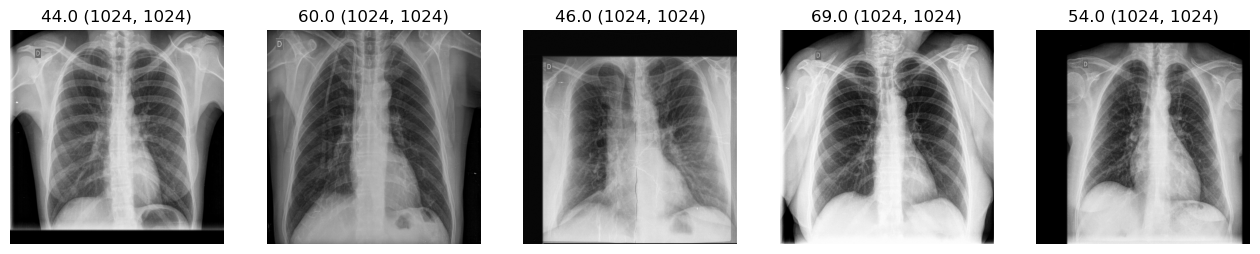

In [230]:
def preview_data(n):
    image_list = ds["train"][:n]["image"]
    labels = ds["train"][:n]["label"]
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(16, 10))
    for i, image in enumerate(image_list):
        axes[i].imshow(image)
        axes[i].set_title(f"{labels[i]} {image.size}")
        axes[i].axis("off")
plt.show()

preview_data(5)

In [231]:
def crop_border(img):
    gs = np.array(img)[..., :3] @ [0.299, 0.587, 0.114]
    rows_to_remove = np.where((gs <= 100).sum(axis=1) == gs.shape[1])[0]
    cols_to_remove = np.where((gs <= 100).sum(axis=0) == gs.shape[0])[0]
    gs = np.delete(gs, rows_to_remove, axis=0)
    gs = np.delete(gs, cols_to_remove, axis=1)
    return PILImage.fromarray(np.uint8(gs) , "L")

def transforms(examples):
    transform = Compose([Resize((224,224))])
    examples["image"] = [transform(crop_border(image).convert("RGB")) for image in examples["image"]]
    examples["pixel_values"] = [np.array(image.getdata(), dtype=np.uint8) for image in examples["image"]]
    return examples

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

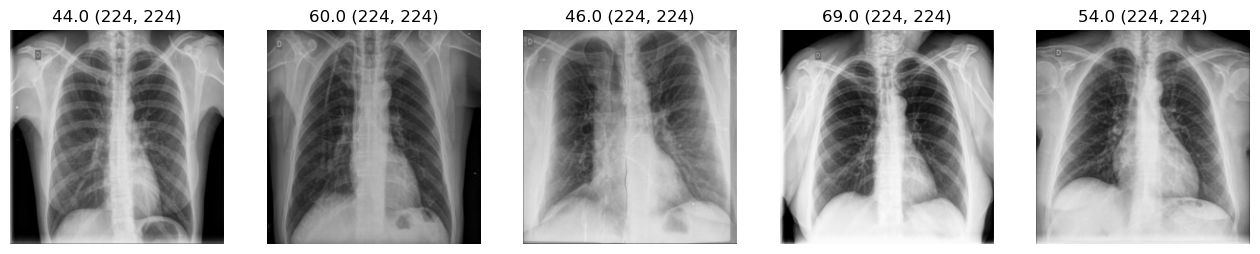

In [232]:
ds = ds.map(transforms, batched=True)
preview_data(5)

In [233]:
ds.set_format(type="torch", columns=["pixel_values", "label"])

In [228]:
class NumericOutputLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return x
    



# Load a pre-trained ViT model for image classification
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Modify the output layer to output a single scalar value
input_dim = model.classifier.in_features
output_dim = 1  # Set the output dimension to 1 for numeric prediction
model.classifier = NumericOutputLayer(input_dim, output_dim)


transform = ToTensor()  
# # Define the data loaders for training and validation
train_loader = torch.utils.data.DataLoader(ds["train"], batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(ds["test"], batch_size=32, shuffle=True)


optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Use the Adam optimizer
loss_fn = nn.L1Loss()  # MAE
num_epochs = 2
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for batch in train_loader:
        inputs = batch["pixel_values"].reshape(32, 1, 224, 224)
        labels = batch["label"]
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch in val_loader:
            inputs = batch["pixel_values"].reshape(32, 1, 224, 224)
            labels = batch["label"]
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * len(inputs)
        val_loss /= len(val_dataset)
        print("Epoch {}, Validation Loss: {:.4f}".format(epoch+1, val_loss))

ValueError: Make sure that the channel dimension of the pixel values match with the one set in the configuration.

In [117]:
a = {"pixel_values": [transform(x) for x in ds["train"]["image"]],
                                            "label": ds["train"]["label"]}
a["pixel_values"][0]

tensor([[[0.1529, 0.0431, 0.0000,  ..., 0.0549, 0.1373, 0.2706],
         [0.1255, 0.0353, 0.0000,  ..., 0.0118, 0.0588, 0.1765],
         [0.1098, 0.0314, 0.0000,  ..., 0.0000, 0.0078, 0.0627],
         ...,
         [0.3294, 0.2039, 0.2118,  ..., 0.0000, 0.0118, 0.0902],
         [0.3176, 0.1922, 0.2039,  ..., 0.0000, 0.0118, 0.1020],
         [0.3059, 0.1843, 0.1961,  ..., 0.0000, 0.0078, 0.0745]]])

In [ ]:
# test_files = os.listdir("/kaggle/input/spr-x-ray-age/kaggle/kaggle/test")
# preds = [float(learn.predict("/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/"+x)[1]) if
#          float(learn.predict("/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/"+x)[1]) > 0 else 0 
#          for x in test_files]
# df = pd.DataFrame({
#     "imageId": [int(x.split(".")[0]) for x in test_files],
#     "age": preds
# })

# df.to_csv("submission.csv", index = False)

In [ ]:
# learn.save("age_model", with_opt=False)